# Local Parameters

In this notebook, we analyze the data containing information about local parameters.
To perform this analysis, it is necessary to first execute the script `dat_local_paramters.py`, which processes the contents of the `dat` folder and generates the following outputs:

- A folder called `dat_local_parameters`, which contains .dat files with the local order parameters for different boxes at each time step and for each seed.

- A folder called `dat_local_phenotype`, which contains .dat files with the local phenotypes for different boxes at each time step and for each seed.

To calculate the local properties of each culture, we use square boxes with side lengths of 5, 10, 15, 20, 25, and 30. For each box size, we randomly choose 10 points within the culture (in the same step and seed) to serve as the box centers. For each box, we compute the local order parameters and phenotypes, then average over the 10 boxes to obtain the local value for that seed. Finally, we average over all seeds.

# Local Order Parameters

We begin analyzing the local order parameters.

## Order parameters evolution

We are going to start seeing how the order parameters change in time for the different boxes.

In [1]:
# import the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

We define some relevant parameters that remains constant during the simulations.

In [2]:
cell_area = np.pi
max_step = 60_000
step = 100
delta_t = 0.05

# All the seeds
number_of_realizations=64

seed_1 = 0x87351080E25CB0FAD77A44A3BE03B491
rng_1 = np.random.default_rng(seed_1)

rng_seed = rng_1.integers(
            low=2**20, high=2**50, size=number_of_realizations
        )

We start creating a function that make a list with the mean of each variable (nematic order 1 and 2, polar order 1 and 2) for each step.

In [3]:
def calculate_local_order_parameters_vs_time(num_cells, dens, max_step, step, rng_seed, box_length):
    """
    Calculates local polar and nematic order parameters as a function of time
    for a given density, list of seeds and size of the box.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    dens : float
        Cell density.
    max_step : int
        Maximum time step to analyze.
    step : int
        Interval between time steps (e.g., every `step` steps).
    rng_seed : list of int
        List of random seeds used in the simulations.
    box_length: float
        Size of the local observation box.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing the local polar and nematic order parameters at 
        different time steps for each seed.
    """

    # Initialize the lists for order parameters 1
    nematic_order = []
    polar_order = []
    # Initialize the lists for order parameters 2
    nematic_2_order = []
    polar_2_order = []
    # Define a boolean to stop where there are no more data
    stop = False
    # Initialize a list with the valid steps
    valid_steps = []
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    for tic in range(100, max_step, step):
        # Initialize arrays to calculate the mean of every seed in this step
        nematic_step = np.array([])
        polar_step = np.array([])
        # and for op 2
        nematic_2_step = np.array([])
        polar_2_step = np.array([])
        # For each seed we read the file
        for seed in rng_seed:
            dat_actual = (
                    f"data/{num_cells_folder}/{dens_folder}/dat_local_op/local_op_box_length={int(box_length)}_culture_initial_number_of_cells={num_cells}_density={dens}_"
                    f"force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_"
                    f"rng_seed={seed}_step={tic:05}.dat"
                )
            if os.path.exists(dat_actual):
                df_tic = pd.read_csv(dat_actual)
            else:
                stop = True
                break
            # Take parameters of this particular seed
            nematic_seed = df_tic["nematic"].mean()
            polar_seed = df_tic["polar"].mean()
            # and for op 2
            nematic_2_seed = df_tic["nematic_2"].mean()
            polar_2_seed = df_tic["polar_2"].mean()
            # Add them to the steps's array
            nematic_step = np.append(nematic_step, nematic_seed)
            polar_step = np.append(polar_step, polar_seed)
            # and for op 2
            nematic_2_step = np.append(nematic_2_step, nematic_2_seed)
            polar_2_step = np.append(polar_2_step, polar_2_seed)
        # We stop reading if the boolean is True
        if stop is True:
            last_step = tic-step
            print("Last step = ", last_step, " for density = ", dens)
            break
        valid_steps.append(tic)
        # Calculate the mean for every seed in that step
        nematic_mean = np.mean(nematic_step)
        polar_mean = np.mean(polar_step)
        # and for op 2
        nematic_2_mean = np.mean(nematic_2_step)
        polar_2_mean = np.mean(polar_2_step)
        # Add them to the global list
        nematic_order.append(nematic_mean)
        polar_order.append(polar_mean)
        # and for op 2
        nematic_2_order.append(nematic_2_mean)
        polar_2_order.append(polar_2_mean)

    # Create the dataframe
    df = pd.DataFrame({
        "step": valid_steps,
        "nematic": nematic_order,
        "polar": polar_order,
        "nematic_2": nematic_2_order,
        "polar_2": polar_2_order,
    })

    return df

We also create a function to plot the order parameters evolution.

In [4]:
def plot_local_order_parameters_evolution(df, dens, num_cells, box_length):
    """
    Plots the temporal evolution of polar and nematic order parameters
    for a given cell density.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing polar and nematic order parameters as a 
        function of time for multiple seeds.
    dens : float
        Cell density used in the simulation.
    num_cells : int
        Number of cells in the simulation.
    box_length: float
        Size of the local observation box.
    """

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # First plot
    axs[0].plot(df["step"], df["nematic"], label="Nematic order (Q)", color="blue")
    axs[0].plot(df["step"], df["polar"], label="Polar order (Q)", color="green")
    axs[0].set_title("Local order parameters 1")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Order parameter")
    axs[0].legend()

    # Second plot
    axs[1].plot(df["step"], df["nematic_2"], label=r"Nematic order ($\hat{Q}$)", color="blue")
    axs[1].plot(df["step"], df["polar_2"], label=r"Polar order ($\hat{P}$)", color="green")
    axs[1].set_title("Local order parameters 2")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Order parameter")
    axs[1].legend()

    fig.suptitle(f"Local order Parameters vs Time (N={num_cells}, density = {dens}, box_length={int(box_length)})")
    plt.tight_layout()

    # Guardar el gráfico
    num_cells_folder = f"N={num_cells:_}"
    folder_path = f"graphs/{num_cells_folder}/local/local_op_evolution"
    os.makedirs(folder_path, exist_ok=True)
    output_path = os.path.join(folder_path, f"local_op_evolution_N={num_cells}_density_{dens:.2f}_box_length={int(box_length)}.png")
    plt.savefig(output_path, dpi=600)

    # Mostrar
    plt.show()

### N=10_000

We can observe the evolution of the local order parameters for each cell density and box size for the case N=10,000. In this notebook, we only show the results for density 0.85, but you can uncomment the density list line or check all the graphs in their corresponding folder.

Last step =  48300  for density =  0.85


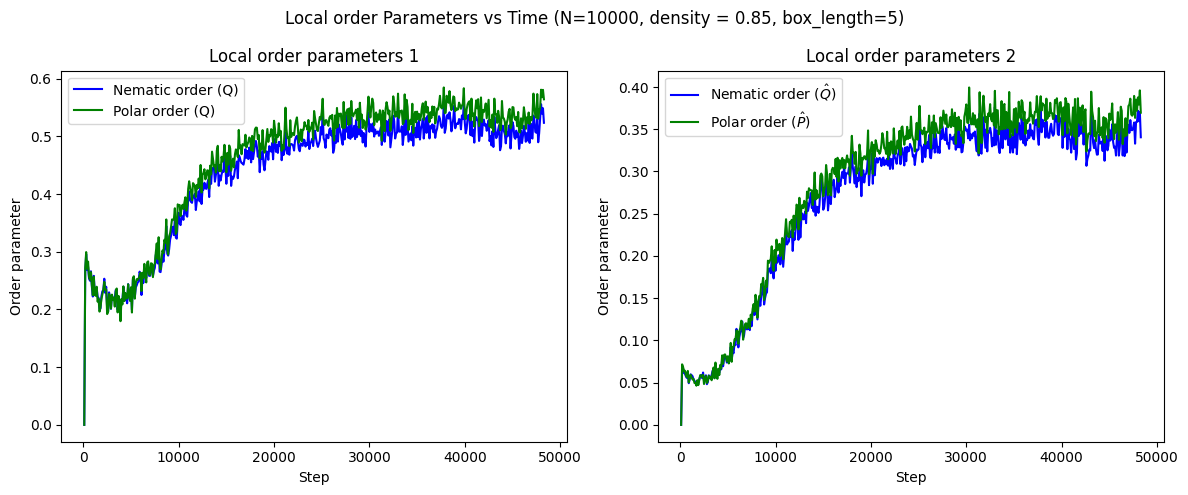

Last step =  48300  for density =  0.85


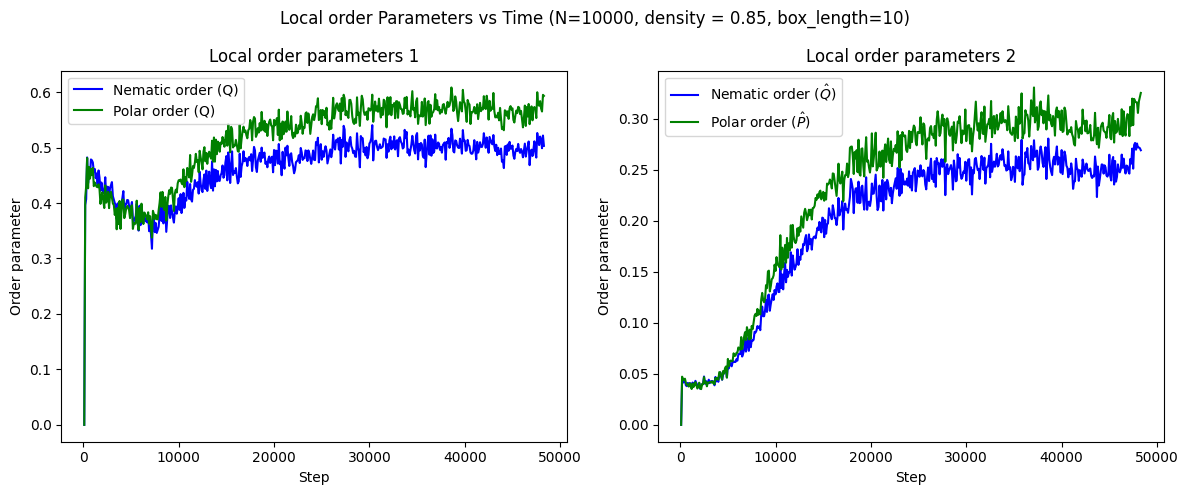

Last step =  48300  for density =  0.85


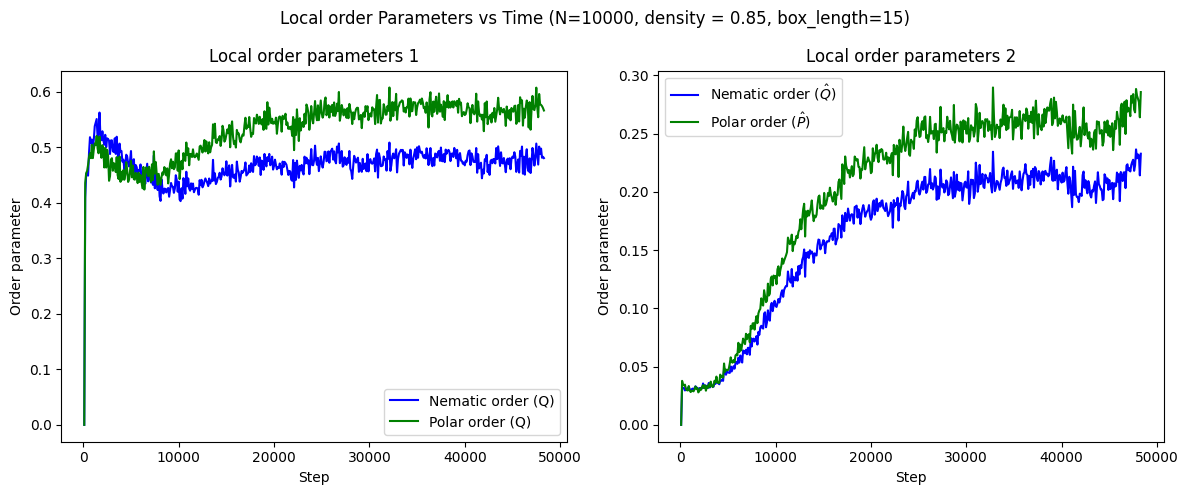

Last step =  48300  for density =  0.85


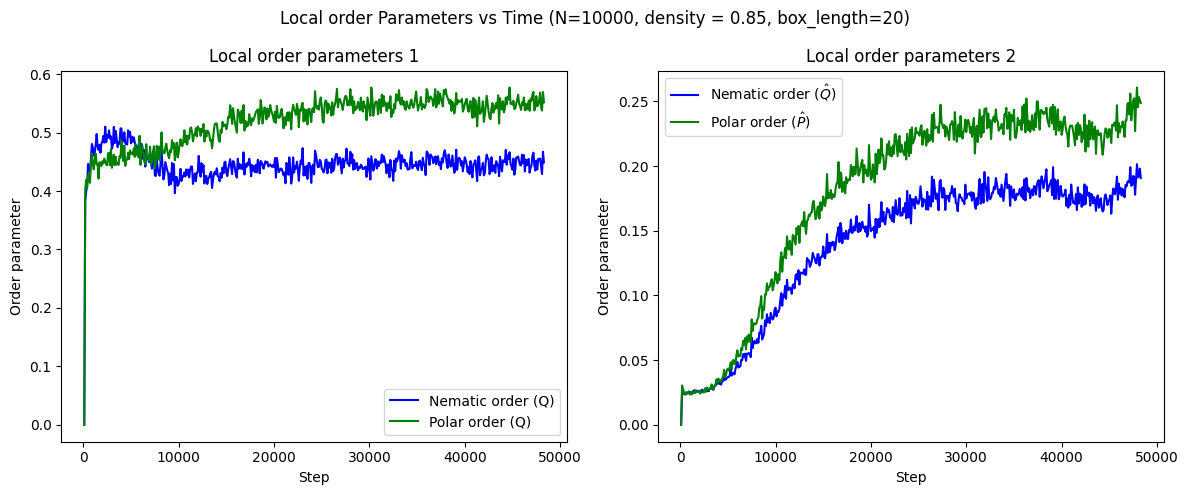

Last step =  48300  for density =  0.85


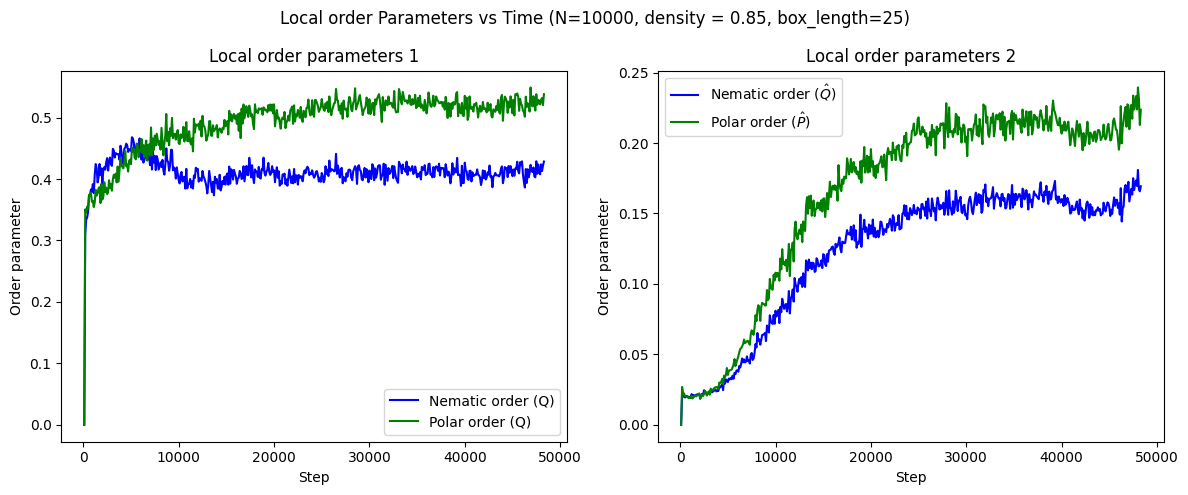

Last step =  48300  for density =  0.85


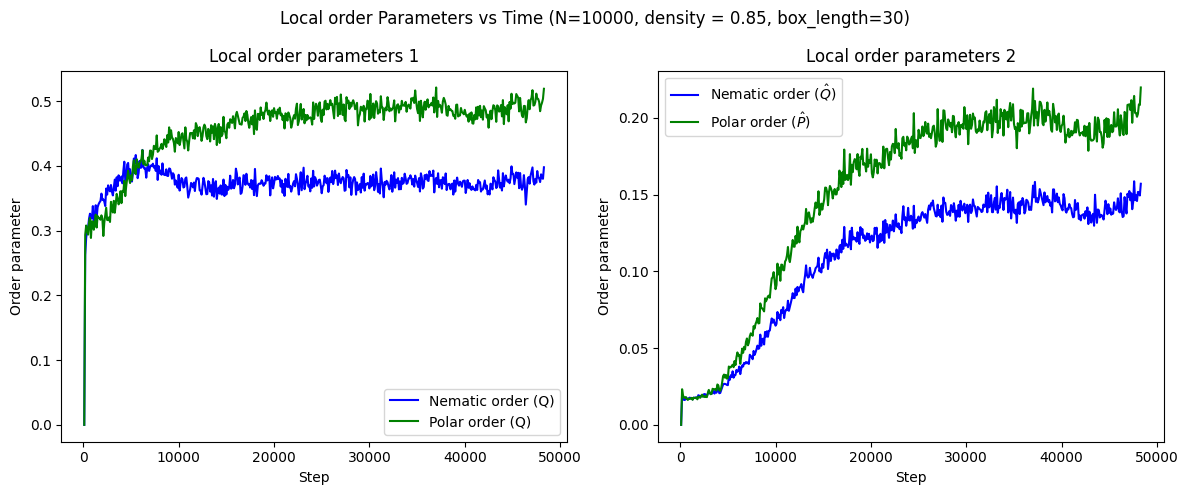

In [5]:
number_of_cells = 10_000
# Create a list with the densities
density_list = [0.85]
# density_list = [0.81, 0.82, 0.83, 0.84, 0.86]
# density_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
# Create a dict to save all the dataframes
dfs = {}
# Create a list with the box sizes
box_length_list = [5, 10, 15, 20, 25, 30]

for density in density_list:
    for box_length in box_length_list:
        # Call the function for the df in that density and box size
        df = calculate_local_order_parameters_vs_time(num_cells=number_of_cells, dens=density, max_step=max_step, step=step, rng_seed=rng_seed, box_length=box_length)
        # df.to_csv(f"{density_folder}/local_op_vs_time_density_{density:.2f}_box_length={int(box_length)}.csv", index=False)
        # Add it to the dict
        dfs[(density, box_length)] = df # we can do, for example, dfs[(0.85, 5)].head()
        # plot
        plot_local_order_parameters_evolution(df, dens=density, num_cells=number_of_cells, box_length=box_length)

### Steady State

Now we can plot how the final order parameters change with the density.

First we create a function to calculate the order parameters of the last step, saving the mean and the standard deviation.

In [5]:
def calculate_final_local_order_parameter(num_cells, max_step, dens, step, rng_seed, box_length):
    """
    Calculates the final local polar and nematic order parameters at the last 
    time step (`max_step`) for a given density, averaging over multiple seeds.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    max_step : int
        Final time step to analyze.
    dens : float
        Cell density used in the simulation.
    step : int
        Time step interval between saved data files.
    rng_seed : list of int
        List of random seeds corresponding to different simulation runs.
    box_length: float
        Size of the local observation box.
        
    Returns
    -------
    dict
        Dictionary with the mean and standard deviation of the polar and 
        nematic order parameters at the final time step.
    """
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    # Define a boolean to stop where there are no more data
    stop = False
    # Check for which was the last step
    for tic in range(100, max_step, step):
        for seed in rng_seed:
            dat_actual = f"data/{num_cells_folder}/{dens_folder}/dat_local_op/local_op_box_length={int(box_length)}_culture_initial_number_of_cells={num_cells}_density={dens}_force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_rng_seed={seed}_step={tic:05}.dat"
            if not os.path.exists(dat_actual):
                stop = True
                break
        if stop is True:
            last_step = tic - step
            break
    else:
        # if the for does not break, last step is the max
        last_step = max_step
    
    print("Last step = ", last_step, " for density = ", dens)
    
    # Initialize the lists for order parameters 1
    nematic_order = []
    polar_order = []
    # and for op 2
    nematic_2_order = []
    polar_2_order = []   
    # For each seed, we read de corresponding file 
    for seed in rng_seed:
        dat_actual = f"data/{num_cells_folder}/{dens_folder}/dat_local_op/local_op_box_length={int(box_length)}_culture_initial_number_of_cells={num_cells}_density={dens}_force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_rng_seed={seed}_step={last_step:05}.dat"

        if not os.path.exists(dat_actual):
            print(f"File not found: {dat_actual}")
            continue
        
        df_tic = pd.read_csv(dat_actual)
        # Take parameters of this particular seed
        nematic_mean = df_tic["nematic"].mean()
        polar_mean = df_tic["polar"].mean()
        # and for op 2
        nematic_2_mean = df_tic["nematic_2"].mean()
        polar_2_mean = df_tic["polar_2"].mean()

        # And add them to the list
        nematic_order.append(nematic_mean)
        polar_order.append(polar_mean)
        # also for op 2
        nematic_2_order.append(nematic_2_mean)
        polar_2_order.append(polar_2_mean)

    # return a dataframe with the mean and std for every op
    return {
        "mean": {
            "nematic_order": np.mean(nematic_order),
            "polar_order": np.mean(polar_order),
            "nematic_order_2": np.mean(nematic_2_order),
            "polar_order_2": np.mean(polar_2_order),
        },
        "std": {
            "nematic_order": np.std(nematic_order),
            "polar_order": np.std(polar_order),
            "nematic_order_2": np.std(nematic_2_order),
            "polar_order_2": np.std(polar_2_order),
        }
    }

Now we use this function to plot the steady states. We will need to create 2 DataFrames with the information of the mean and standard deviation for every density and give them to the plot function.

In [6]:
def plot_mean_and_variance_steady_states_op(df_mean, df_std, error_bars, var_names, labels, output_path, title):
    """
    Plots the mean and variance of each order parameter in the steady state.

    Parameters
    ----------
    df_mean : pandas.DataFrame
        DataFrame with mean values.
    df_std : pandas.DataFrame
        DataFrame with std values.
    error_bars : pandas.DataFrame
        DataFrame with standard error of the mean.
    var_names : list
        List of 2 labels for the legend.
    labels : list
        List of 2 labels for the legend.
    output_path: str
        Path to save the figure
    title: str
        Title of the whole figure
    """

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    color1, color2 = "blue", "green"
    
    # First plot: mean with error bars
    axes[0].errorbar(df_mean["density"], df_mean[var_names[0]], 
                 yerr=error_bars[var_names[0] + "_std"], fmt='o-', color=color1, label=labels[0])
    axes[0].errorbar(df_mean["density"], df_mean[var_names[1]], 
                 yerr=error_bars[var_names[1] + "_std"], fmt='o-', color=color2, label=labels[1])
    axes[0].set_xlabel("Density ρ")
    axes[0].set_ylabel("Order parameter (mean)")
    axes[0].set_title("Mean ± Std Error")
    axes[0].legend()

    # Second plot: variance
    axes[1].plot(df_mean["density"], df_std[var_names[0] + "_std"]**2, marker='o', linestyle='--', color=color1, label=f"Var({labels[0]})")
    axes[1].plot(df_mean["density"], df_std[var_names[1] + "_std"]**2, marker='o', linestyle='--', color=color2, label=f"Var({labels[1]})")
    axes[1].set_xlabel("Density ρ")
    axes[1].set_ylabel("Variance")
    axes[1].set_title("Variance")
    axes[1].legend()

    fig.suptitle(title)
    plt.savefig(output_path, dpi=600)
    plt.show()
    plt.close()

### N=10_000

Let's see the steady state of every density and box size for N=10_000. In this notebook, we only show the results for box size 5, but you can uncomment the density list line or check all the graphs in their corresponding folder.

Last step =  50000  for density =  0.4
Last step =  50000  for density =  0.5
Last step =  50000  for density =  0.6
Last step =  50000  for density =  0.7
Last step =  50000  for density =  0.8
Last step =  33000  for density =  0.81
Last step =  50000  for density =  0.82
Last step =  47700  for density =  0.83
Last step =  45500  for density =  0.84
Last step =  48300  for density =  0.85
Last step =  27700  for density =  0.86
Last step =  17500  for density =  0.87
Last step =  10000  for density =  0.88
Last step =  10000  for density =  0.9


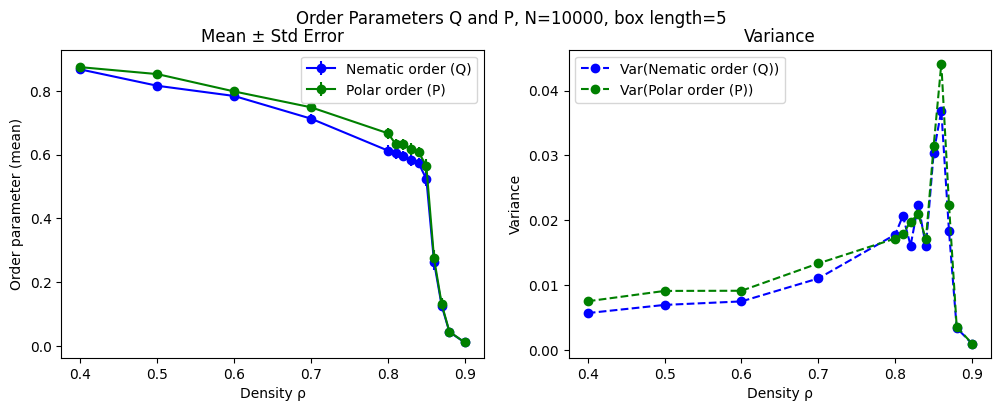

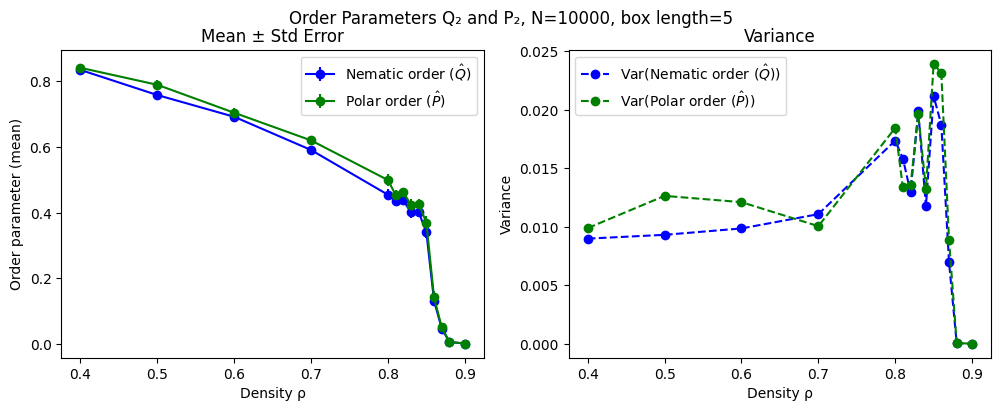

In [8]:
number_of_cells= 10_000
# Create a list with the densities
density_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
# Create a list with the box sizes
box_length_list = [5]
# box_length_list = [5, 10, 15, 20, 25, 30]

for box_length in box_length_list:
    # Define DataFrames to save means and stds
    df_mean = pd.DataFrame(columns=["density", "nematic_order", "polar_order", "nematic_order_2", "polar_order_2"])
    df_std = pd.DataFrame(columns=["density", "nematic_order_std", "polar_order_std", "nematic_order_2_std", "polar_order_2_std"])

    # For each density, calculate the order parameters and add the results to the dataframes
    for dens in density_list:
        result = calculate_final_local_order_parameter(number_of_cells, max_step + 1, dens, step, rng_seed, box_length)
        mean = result["mean"]
        std = result["std"]

        df_mean.loc[len(df_mean)] = [dens, mean["nematic_order"], mean["polar_order"], mean["nematic_order_2"], mean["polar_order_2"]]
        df_std.loc[len(df_std)] = [dens, std["nematic_order"], std["polar_order"], std["nematic_order_2"], std["polar_order_2"]]

    # Caclulate the length of the error bars
    error_bars = df_std / np.sqrt(number_of_realizations)

    num_cells_folder = f"N={number_of_cells:_}"
    folder_path = f"graphs/{num_cells_folder}/local/local_op_steady_state"
    os.makedirs(folder_path, exist_ok=True)

    plot_mean_and_variance_steady_states_op(
        df_mean=df_mean,
        df_std=df_std,
        error_bars=error_bars,
        var_names=["nematic_order", "polar_order"],
        labels=["Nematic order (Q)", "Polar order (P)"],
        output_path=f"graphs/{num_cells_folder}/local/local_op_steady_state/op_steady_state_N={number_of_cells}_box_length={int(box_length)}.png",
        title=f"Order Parameters Q and P, N={number_of_cells}, box length={int(box_length)}"
    )

    plot_mean_and_variance_steady_states_op(
        df_mean=df_mean,
        df_std=df_std,
        error_bars=error_bars,
        var_names=["nematic_order_2", "polar_order_2"],
        labels=[r"Nematic order ($\hat{Q}$)", r"Polar order ($\hat{P}$)"],
        output_path=f"graphs/{num_cells_folder}/local/local_op_steady_state/op_2_steady_state_N={number_of_cells}_box_length={int(box_length)}.png",
        title=f"Order Parameters Q₂ and P₂, N={number_of_cells}, box length={int(box_length)}"
)

# Local Phenotypes

We can also explore the local phenotypes.

We start creating a function that make a list with the mean of each phenotype for each step.

In [7]:
def calculate_local_phenotype_vs_time(num_cells, dens, max_step, step, rng_seed, box_length):
    """
    Calculates local phenotypes and the aspect ratio as a function of time
    for a given density and list of seeds.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    dens : float
        Cell density.
    max_step : int
        Maximum time step to analyze.
    step : int
        Interval between time steps (e.g., every `step` steps).
    rng_seed : list of int
        List of random seeds used in the simulations.
    box_length: float
        Size of the local observation box.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing the phenotypes and aspect ratio at 
        different time steps for each seed.
    """

    # Initialize the lists for each phenotype and the aspect ratio
    fraction_elongated = []
    fraction_round = []
    fraction_binary = []
    mean_aspect_ratio = []
    # Define a boolean to stop where there are no more data
    stop = False
    # Initialize a list with the valid steps
    valid_steps = []
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    for tic in range(100, max_step, step):
        # Initialize arrays to calculate the mean of every seed in this step
        fraction_elongated_cells_step = np.array([])
        fraction_round_cells_step = np.array([])
        fraction_binary_cells_step = np.array([])
        mean_aspect_ratio_step = np.array([])
        # For each seed we read the file
        for seed in rng_seed:
            dat_actual = (
                    f"data/{num_cells_folder}/{dens_folder}/dat_local_phenotype/local_phenotype_box_length={int(box_length)}_culture_initial_number_of_cells={num_cells}_density={dens}_"
                    f"force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_"
                    f"rng_seed={seed}_step={tic:05}.dat"
                )
            if os.path.exists(dat_actual):
                df_tic = pd.read_csv(dat_actual)
            else:
                stop = True
                break
            # Take parameters of this particular seed
            mean_aspect_ratio_seed = df_tic["mean_aspect_ratio"].mean()
            fraction_elongated_seed = df_tic["fraction_elongated"].mean()
            fraction_round_seed = df_tic["fraction_round"].mean()
            fraction_binary_seed = df_tic["fraction_binary"].mean()
            # Add them to the steps's array
            mean_aspect_ratio_step = np.append(mean_aspect_ratio_step, mean_aspect_ratio_seed)
            fraction_elongated_cells_step = np.append(fraction_elongated_cells_step, fraction_elongated_seed)
            fraction_round_cells_step = np.append(fraction_round_cells_step, fraction_round_seed)
            fraction_binary_cells_step = np.append(fraction_binary_cells_step, fraction_binary_seed)
        # We stop reading if the boolean is True
        if stop is True:
            last_step = tic-step
            print("Last step = ", last_step, " for density = ", dens)
            break
        valid_steps.append(tic)
        # Calculate the mean for every seed in that step
        mean_aspect_ratio_mean = np.mean(mean_aspect_ratio_step)
        fraction_elongated_mean = np.mean(fraction_elongated_cells_step)
        fraction_round_mean = np.mean(fraction_round_cells_step)
        fraction_binary_mean = np.mean(fraction_binary_cells_step)

        # Add them to the global list
        mean_aspect_ratio.append(mean_aspect_ratio_mean)
        fraction_elongated.append(fraction_elongated_mean)
        fraction_round.append(fraction_round_mean)
        fraction_binary.append(fraction_binary_mean)

    # Create the dataframe
    df = pd.DataFrame({
        "step": valid_steps,
        "mean_aspect_ratio": mean_aspect_ratio,
        "fraction_elongated": fraction_elongated,
        "fraction_round": fraction_round,
        "fraction_binary": fraction_binary,
    })

    return df

We also create a function to plot the local phenotypes evolution.

In [8]:
def plot_local_phenotype_evolution(df, dens, num_cells, box_length):
    """
    Plots the temporal evolution of the local phenotypes and mean aspect ratio
    for a given cell density.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the phenotypes and aspect ratio at 
        different time steps for each seed.
    dens : float
        Cell density used in the simulation.
    num_cells : int
        Number of cells in the simulation.
    box_length: float
        Size of the local observation box.
    """

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # First plot
    axs[0].plot(df["step"], df["fraction_elongated"], label="Fraction of elongated cells", color="red")
    axs[0].plot(df["step"], df["fraction_round"], label="Fraction of round cells", color="blue")
    axs[0].plot(df["step"], df["fraction_binary"], label="Fraction of binary cells", color="green")
    axs[0].set_title("Phenotypes")
    axs[0].set_ylabel("Fraction of cells")
    axs[0].legend()

    # Second plot
    axs[1].plot(df["step"], df["mean_aspect_ratio"], label="Mean aspect ratio", color="orange")
    axs[1].set_title("Mean aspect ratio")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Aspect ratio")
    axs[1].legend()

    fig.suptitle(f"Local phenotypes and Mean Aspect Ratio vs Time (N={num_cells}, density = {dens}, box_length={int(box_length)})")
    plt.tight_layout()

    # Guardar el gráfico
    num_cells_folder = f"N={num_cells:_}"
    folder_path = f"graphs/{num_cells_folder}/local/local_ph_evolution"
    os.makedirs(folder_path, exist_ok=True)
    output_path = os.path.join(folder_path, f"local_ph_evolution_N={num_cells}_density_{dens:.2f}_box_length={int(box_length)}.png")
    plt.savefig(output_path, dpi=600)

    # Mostrar
    plt.show()

### N=10_000

We can observe the evolution of the local phenotypes for each cell density and box size for the case N=10,000. In this notebook, we only show the results for density 0.85, but you can uncomment the density list line or check all the graphs in their corresponding folder.

Last step =  48300  for density =  0.85


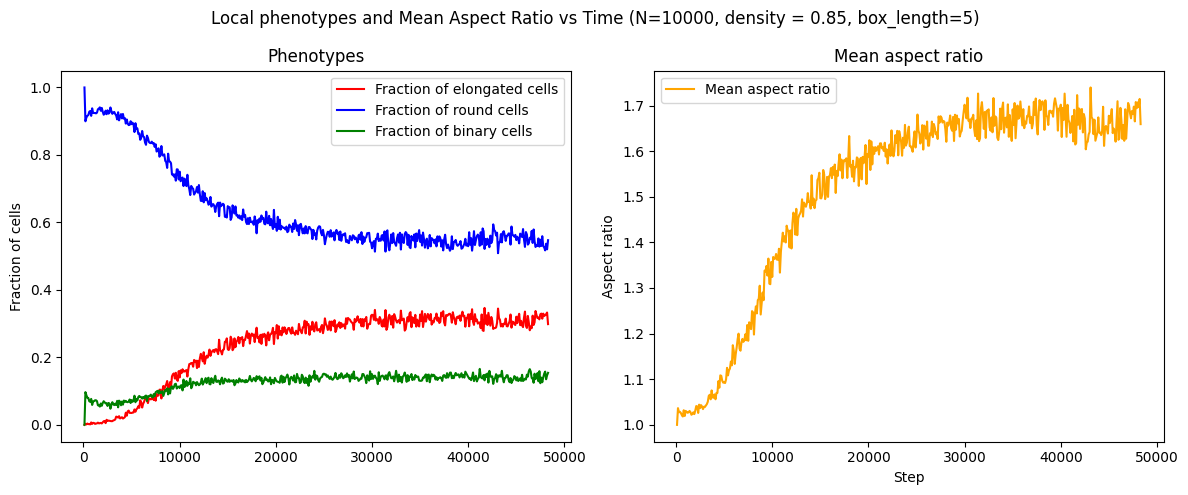

Last step =  48300  for density =  0.85


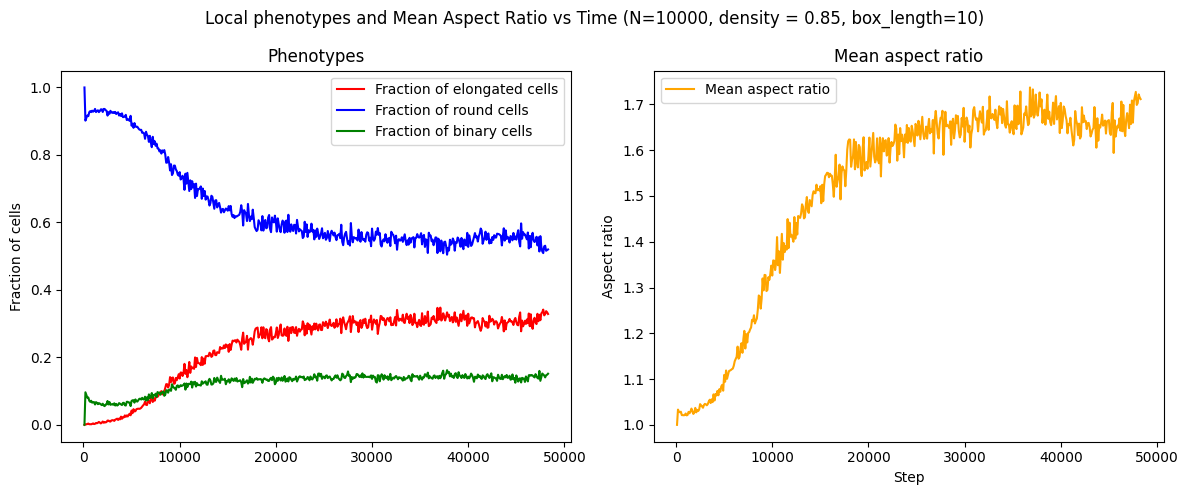

Last step =  48300  for density =  0.85


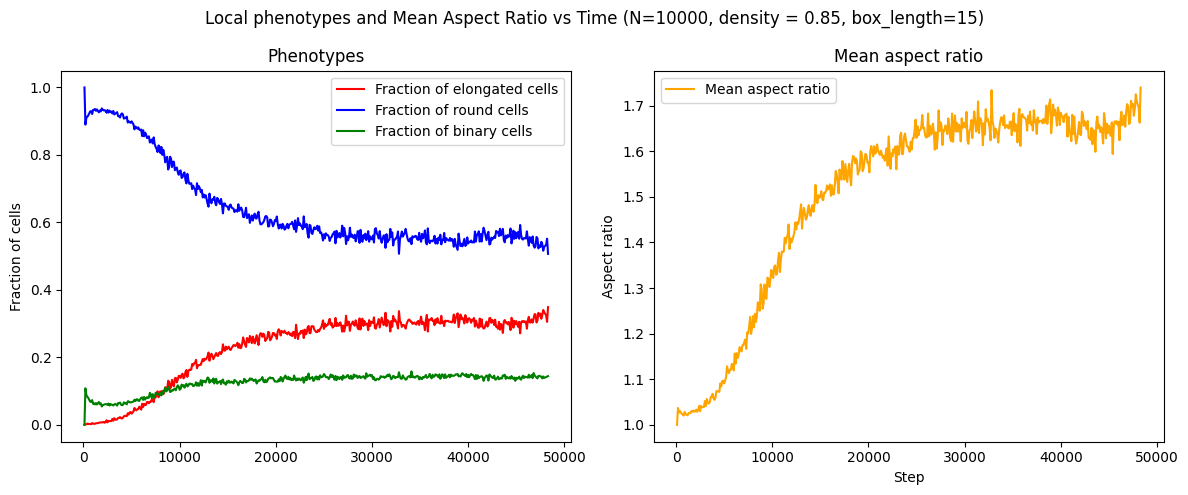

Last step =  48300  for density =  0.85


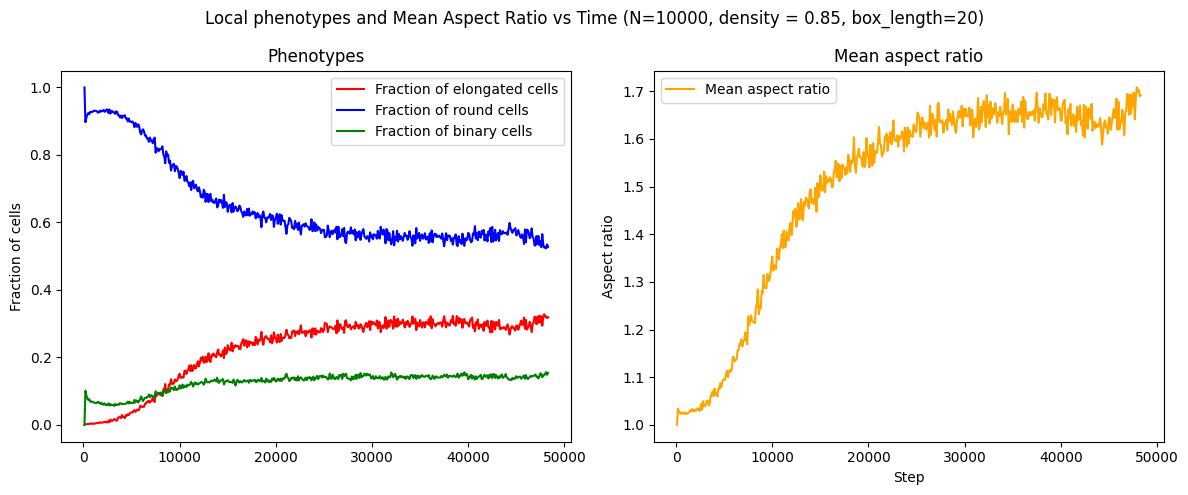

Last step =  48300  for density =  0.85


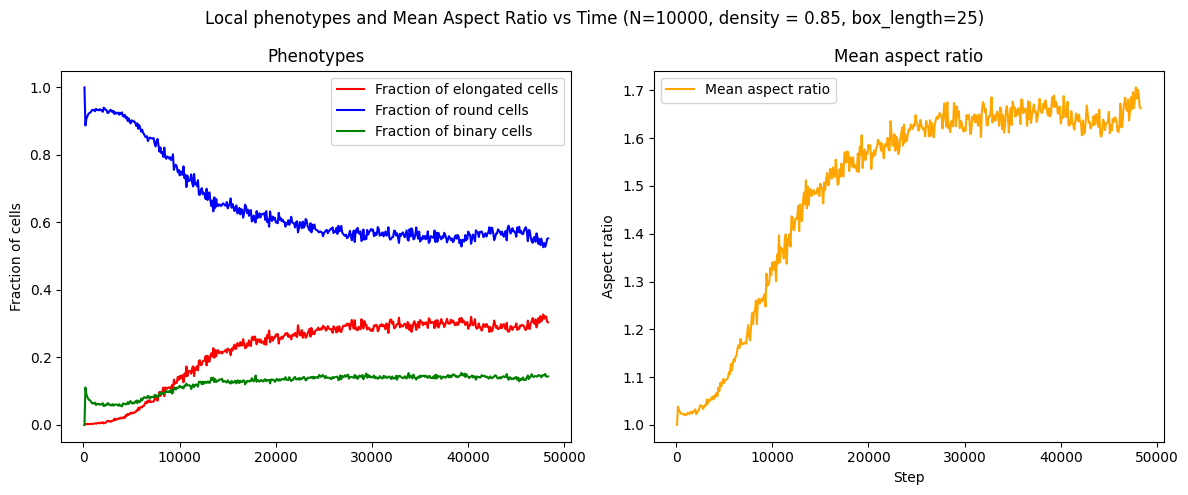

Last step =  48300  for density =  0.85


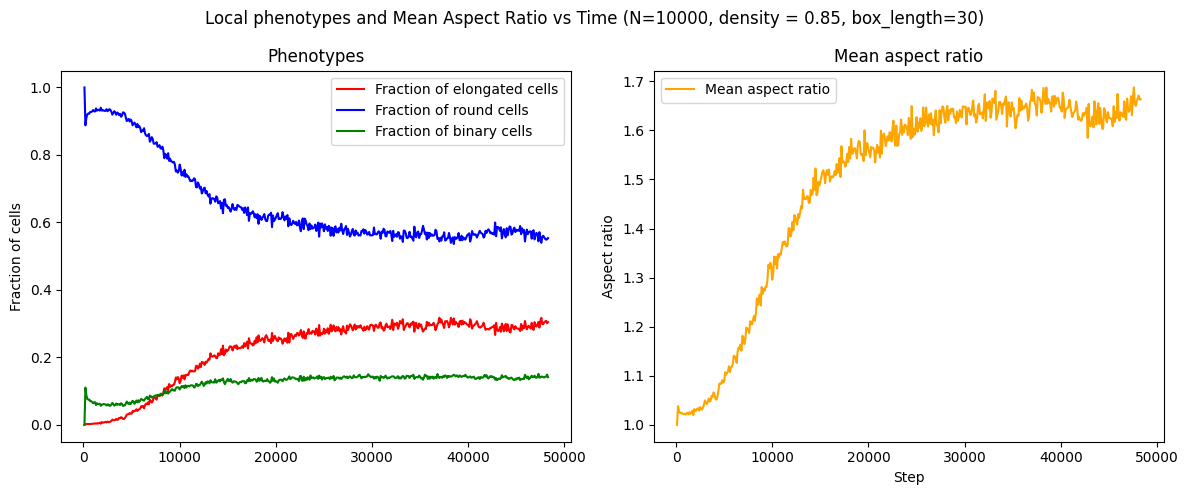

In [11]:
number_of_cells = 10_000
# Create a list with the densities
density_list = [0.85]
# density_list = [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
# Create a dict to save all the dataframes
dfs = {}
# Create a list with the box sizes
box_length_list = [5, 10, 15, 20, 25, 30]

for density in density_list:
    for box_length in box_length_list:
        # Call the function for the df in that density and box size
        df = calculate_local_phenotype_vs_time(num_cells=number_of_cells, dens=density, max_step=max_step, step=step, rng_seed=rng_seed, box_length=box_length)
        # df.to_csv(f"{density_folder}/local_op_vs_time_density_{density:.2f}_box_length={int(box_length)}.csv", index=False)
        # Add it to the dict
        dfs[(density, box_length)] = df # we can do, for example, dfs[(0.85, 5)].head()
        # plot
        plot_local_phenotype_evolution(df, dens=density, num_cells=number_of_cells, box_length=box_length)

### Steady State

Now we can plot how the final phenotypes change with the density.

First we create a function to calculate the local phenotypes of the last step, saving the mean and the standard deviation.

In [9]:
def calculate_final_local_phenotype(num_cells, max_step, dens, step, rng_seed, box_length):
    """
    Calculates the final phenotypes at the last time step (`max_step`) for a
    given density, averaging over multiple seeds.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    max_step : int
        Final time step to analyze.
    dens : float
        Cell density used in the simulation.
    step : int
        Time step interval between saved data files.
    rng_seed : list of int
        List of random seeds corresponding to different simulation runs.
    box_length: float
        Size of the local observation box.
        
    Returns
    -------
    dict
        Dictionary with the mean and standard deviation of the phenotypes 
        at the final time step.
    """
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    # Define a boolean to stop where there are no more data
    stop = False
    # Check for which was the last step
    for tic in range(100, max_step, step):
        for seed in rng_seed:
            dat_actual = f"data/{num_cells_folder}/{dens_folder}/dat_local_phenotype/local_phenotype_box_length={int(box_length)}_culture_initial_number_of_cells={num_cells}_density={dens}_force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_rng_seed={seed}_step={tic:05}.dat"
            if not os.path.exists(dat_actual):
                stop = True
                break
        if stop is True:
            last_step = tic - step
            break
    else:
        # if the for does not break, last step is the max
        last_step = max_step
    
    print("Last step = ", last_step, " for density = ", dens)
    
    # Initialize the lists for each phenotype and the aspect ratio
    fraction_elongated = []
    fraction_round = []
    fraction_binary = []
    mean_aspect_ratio = []
    # For each seed, we read de corresponding file 
    for seed in rng_seed:
        dat_actual = f"data/{num_cells_folder}/{dens_folder}/dat_local_phenotype/local_phenotype_box_length={int(box_length)}_culture_initial_number_of_cells={num_cells}_density={dens}_force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_rng_seed={seed}_step={last_step:05}.dat"

        if not os.path.exists(dat_actual):
            print(f"File not found: {dat_actual}")
            continue
        
        df_tic = pd.read_csv(dat_actual)
        # Take parameters of this particular seed
        mean_aspect_ratio_mean = df_tic["mean_aspect_ratio"].mean()
        fraction_elongated_mean = df_tic["fraction_elongated"].mean()
        fraction_round_mean = df_tic["fraction_round"].mean()
        fraction_binary_mean = df_tic["fraction_binary"].mean()

        # And add them to the list
        mean_aspect_ratio.append(mean_aspect_ratio_mean)
        fraction_elongated.append(fraction_elongated_mean)
        fraction_round.append(fraction_round_mean)
        fraction_binary.append(fraction_binary_mean)

    # return a dataframe with the mean and std for every op
    return {
        "mean": {
            "mean_aspect_ratio": np.mean(mean_aspect_ratio),
            "fraction_elongated": np.mean(fraction_elongated),
            "fraction_round": np.mean(fraction_round),
            "fraction_binary": np.mean(fraction_binary),
        },
        "std": {
            "mean_aspect_ratio": np.std(mean_aspect_ratio),
            "fraction_elongated": np.std(fraction_elongated),
            "fraction_round": np.std(fraction_round),
            "fraction_binary": np.std(fraction_binary),
        }
    }

Now we use this function to plot the steady states. We will need to create 2 DataFrames with the information of the mean and standard deviation for every density and give them to the plot function.

In [10]:
def plot_mean_and_variance_steady_states_ph(df_mean, df_std, error_bars, var_names, labels, output_path, title):
    """
    Plots the mean and variance of each phenotype in the steady state.

    Parameters
    ----------
    df_mean : pandas.DataFrame
        DataFrame with mean values.
    df_std : pandas.DataFrame
        DataFrame with std values.
    error_bars : pandas.DataFrame
        DataFrame with standard error of the mean.
    var_names : list
        List of 2 labels for the legend.
    labels : list
        List of 2 labels for the legend.
    output_path: str
        Path to save the figure
    title: str
        Title of the whole figure
    """

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    plt.subplots_adjust(hspace=0.4)

    color1, color2, color3, color4 = "red", "blue", "green", "orange"
    
    # First plot: mean with error bars phenotypes
    axes[0, 0].errorbar(df_mean["density"], df_mean[var_names[0]], 
                 yerr=error_bars[var_names[0] + "_std"], fmt='o-', color=color1, label=labels[0])
    axes[0, 0].errorbar(df_mean["density"], df_mean[var_names[1]], 
                 yerr=error_bars[var_names[1] + "_std"], fmt='o-', color=color2, label=labels[1])
    axes[0, 0].errorbar(df_mean["density"], df_mean[var_names[2]], 
                 yerr=error_bars[var_names[2] + "_std"], fmt='o-', color=color3, label=labels[2])
    axes[0, 0].set_xlabel("Density ρ")
    axes[0, 0].set_ylabel("Fraction of cells (mean)")
    axes[0, 0].set_title("Mean ± Std Error")
    axes[0, 0].legend()

    # Second plot: variance phenotypes
    axes[0, 1].plot(df_mean["density"], df_std[var_names[0] + "_std"]**2, marker='o', linestyle='--', color=color1, label=f"Var({labels[0]})")
    axes[0, 1].plot(df_mean["density"], df_std[var_names[1] + "_std"]**2, marker='o', linestyle='--', color=color2, label=f"Var({labels[1]})")
    axes[0, 1].plot(df_mean["density"], df_std[var_names[2] + "_std"]**2, marker='o', linestyle='--', color=color3, label=f"Var({labels[2]})")
    axes[0, 1].set_xlabel("Density ρ")
    axes[0, 1].set_ylabel("Variance")
    axes[0, 1].set_title("Variance")
    axes[0, 1].legend()

    # Third plot: mean with error bars mean aspect ratio
    axes[1, 0].errorbar(df_mean["density"], df_mean[var_names[3]], 
                 yerr=error_bars[var_names[3] + "_std"], fmt='o-', color=color4, label=labels[3])
    axes[1, 0].set_xlabel("Density ρ")
    axes[1, 0].set_ylabel("Aspect ratio (mean)")
    axes[1, 0].set_title("Mean ± Std Error")
    axes[1, 0].legend()

    # Second plot: variance mean aspect ratio
    axes[1, 1].plot(df_mean["density"], df_std[var_names[3] + "_std"]**2, marker='o', linestyle='--', color=color4, label=f"Var({labels[3]})")
    axes[1, 1].set_xlabel("Density ρ")
    axes[1, 1].set_ylabel("Variance")
    axes[1, 1].set_title("Variance")
    axes[1, 1].legend()

    fig.suptitle(title)
    plt.savefig(output_path, dpi=600)
    plt.show()
    plt.close()

### N=10_000

Let's see the steady state of every density and box size for N=10_000. In this notebook, we only show the results for box size 5, but you can uncomment the density list line or check all the graphs in their corresponding folder.

Last step =  50000  for density =  0.4
Last step =  50000  for density =  0.5
Last step =  50000  for density =  0.6
Last step =  50000  for density =  0.7
Last step =  50000  for density =  0.8
Last step =  33000  for density =  0.81
Last step =  50000  for density =  0.82
Last step =  47700  for density =  0.83
Last step =  45500  for density =  0.84
Last step =  48300  for density =  0.85
Last step =  27700  for density =  0.86
Last step =  17500  for density =  0.87
Last step =  10000  for density =  0.88
Last step =  10000  for density =  0.9


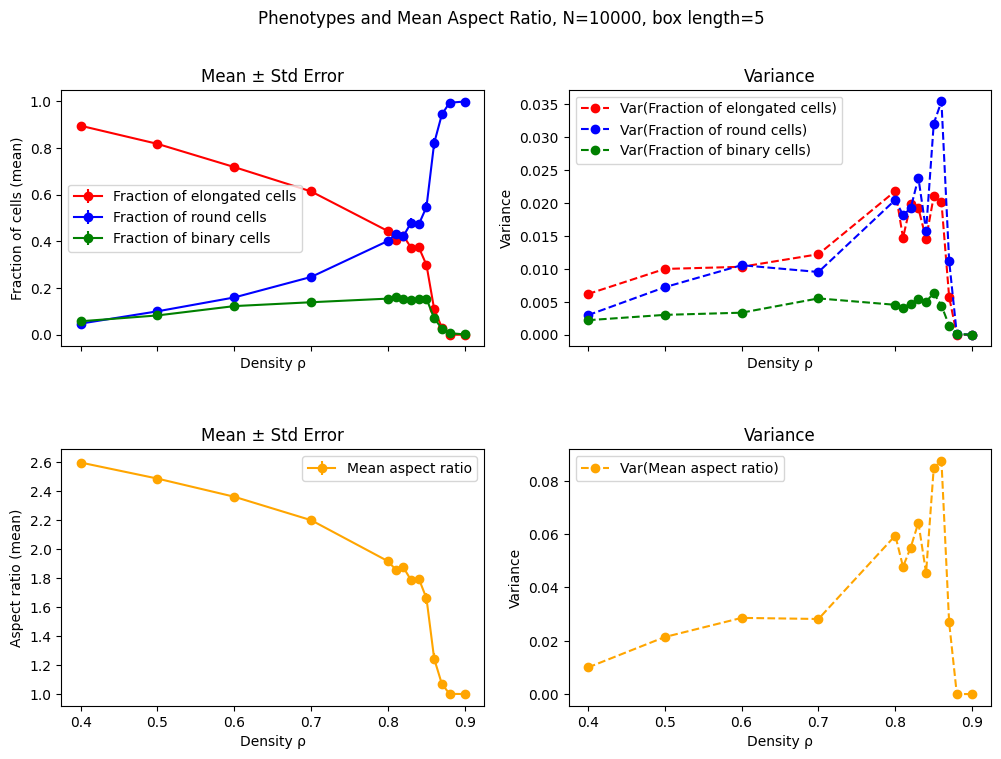

In [11]:
number_of_cells= 10_000
# Create a list with the densities
density_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
# Create a list with the box sizes
box_length_list = [5]
# box_length_list = [5, 10, 15, 20, 25, 30]

for box_length in box_length_list:
    # Define DataFrames to save means and stds
    df_mean = pd.DataFrame(columns=["density", "mean_aspect_ratio", "fraction_elongated", "fraction_round", "fraction_binary"])
    df_std = pd.DataFrame(columns=["density", "mean_aspect_ratio_std", "fraction_elongated_std", "fraction_round_std", "fraction_binary_std"])

    # For each density, calculate the phenotypes and add the results to the dataframes
    for dens in density_list:
        result = calculate_final_local_phenotype(number_of_cells, max_step + 1, dens, step, rng_seed, box_length)
        mean = result["mean"]
        std = result["std"]

        df_mean.loc[len(df_mean)] = [dens, mean["mean_aspect_ratio"], mean["fraction_elongated"], mean["fraction_round"], mean["fraction_binary"]]
        df_std.loc[len(df_std)] = [dens, std["mean_aspect_ratio"], std["fraction_elongated"], std["fraction_round"], std["fraction_binary"]]

    # Caclulate the length of the error bars
    error_bars = df_std / np.sqrt(number_of_realizations)

    num_cells_folder = f"N={number_of_cells:_}"
    folder_path = f"graphs/{num_cells_folder}/local/local_ph_steady_state"
    os.makedirs(folder_path, exist_ok=True)

    plot_mean_and_variance_steady_states_ph(
        df_mean=df_mean,
        df_std=df_std,
        error_bars=error_bars,
        var_names=["fraction_elongated", "fraction_round", "fraction_binary", "mean_aspect_ratio"],
        labels=["Fraction of elongated cells", "Fraction of round cells", "Fraction of binary cells", "Mean aspect ratio"],
        output_path=f"graphs/{num_cells_folder}/local/local_ph_steady_state/ph_steady_state_N={number_of_cells}_box_length={int(box_length)}.png",
        title=f"Phenotypes and Mean Aspect Ratio, N={number_of_cells}, box length={int(box_length)}"
    )

# Length correlation

In this part we are going to analyze how the local order parameters change when we change the box size.

## N=10_000

For this, we can use the calculate final order parameters function. One more time, we only show the results for density 0.85, but you can uncomment the density list line or check all the graphs in their corresponding folder.

Last step =  48300  for density =  0.85
Last step =  48300  for density =  0.85
Last step =  48300  for density =  0.85
Last step =  48300  for density =  0.85
Last step =  48300  for density =  0.85
Last step =  48300  for density =  0.85


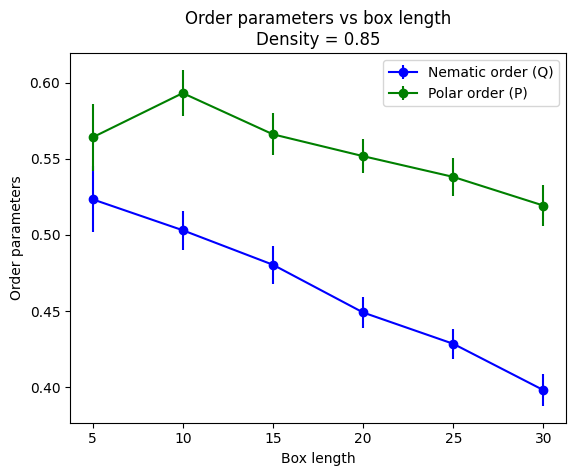

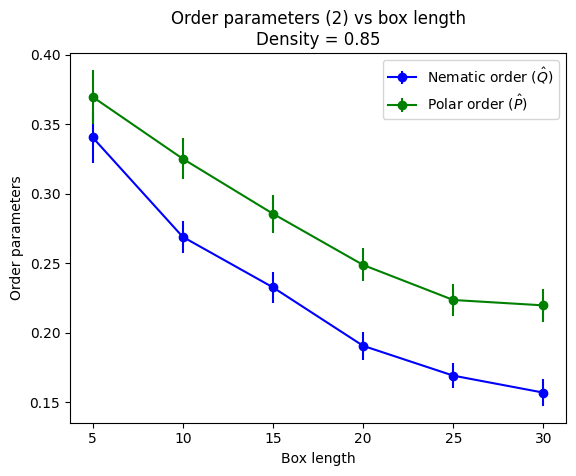

In [12]:
number_of_cells = 10_000
num_cells_folder = f"N={number_of_cells:_}"
# Create a list with the densities
density_list = [0.85]
# density_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
# Create a list with the box sizes
box_length_list = [5, 10, 15, 20, 25, 30]

# Ouput folders
os.makedirs(f"graphs/{num_cells_folder}/local/local_order_vs_boxlength/order_parameters_1", exist_ok=True)
os.makedirs(f"graphs/{num_cells_folder}/local/local_order_vs_boxlength/order_parameters_2", exist_ok=True)

# Iteramos sobre densidades (y graficamos vs box_length)
for dens in density_list:
    df_mean = pd.DataFrame(columns=["box_length", "nematic_order", "polar_order", "nematic_order_2", "polar_order_2"])
    df_std = pd.DataFrame(columns=["box_length", "nematic_order_std", "polar_order_std", "nematic_order_2_std", "polar_order_2_std"])
    
    for box_length in box_length_list:
        result = calculate_final_local_order_parameter(number_of_cells, max_step+1, dens, step, rng_seed, box_length)
        mean = result["mean"]
        std = result["std"]

        df_mean.loc[len(df_mean)] = [box_length, mean["nematic_order"], mean["polar_order"], mean["nematic_order_2"], mean["polar_order_2"]]
        df_std.loc[len(df_std)] = [box_length, std["nematic_order"], std["polar_order"], std["nematic_order_2"], std["polar_order_2"]]

    # Caclulate the length of the error bars
    error_bars = df_std / np.sqrt(number_of_realizations)

    # First plot: Q y P
    fig, ax = plt.subplots()
    ax.errorbar(df_mean["box_length"], df_mean["nematic_order"],
                yerr=error_bars["nematic_order_std"], fmt='o-', color="blue", label="Nematic order (Q)")
    ax.errorbar(df_mean["box_length"], df_mean["polar_order"],
                yerr=error_bars["polar_order_std"], fmt='o-', color="green", label="Polar order (P)")
    ax.set_xlabel("Box length")
    ax.set_ylabel("Order parameters")
    ax.legend()
    plt.title(f"Order parameters vs box length\nDensity = {dens}")
    plt.savefig(f"graphs/{num_cells_folder}/local/local_order_vs_boxlength/order_parameters_1/order_vs_box_length_density={dens:.2f}.jpg", dpi=600)
    plt.show()
    plt.close()

    # Second plot: Q̂ y P̂
    fig, ax = plt.subplots()
    ax.errorbar(df_mean["box_length"], df_mean["nematic_order_2"],
                yerr=error_bars["nematic_order_2_std"], fmt='o-', color="blue", label=r"Nematic order ($\hat{{Q}}$)")
    ax.errorbar(df_mean["box_length"], df_mean["polar_order_2"],
                yerr=error_bars["polar_order_2_std"], fmt='o-', color="green", label=r"Polar order ($\hat{{P}}$)")
    ax.set_xlabel("Box length")
    ax.set_ylabel("Order parameters")
    ax.legend()
    plt.title(f"Order parameters (2) vs box length\nDensity = {dens}")
    plt.savefig(f"graphs/{num_cells_folder}/local/local_order_vs_boxlength/order_parameters_2/order_2_vs_box_length_density={dens:.2f}.jpg", dpi=600)
    plt.show()
    plt.close()
